In [19]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def read_json_files_to_dataframe(folder_path):
    """
    Read all JSON files in the specified folder into a single DataFrame.
    
    Parameters:
    folder_path (str): Path to the folder containing JSON files.
    
    Returns:
    pandas.DataFrame: DataFrame containing the combined data from all JSON files.
    """
    # Check if the folder exists
    if not os.path.isdir(folder_path):
        raise ValueError(f"The folder '{folder_path}' does not exist.")

    # Get list of JSON files in the folder
    json_files = [file for file in os.listdir(folder_path) if file.endswith('.json')]

    # Initialize an empty list to store DataFrames
    dfs = []

    # Read each JSON file into a DataFrame and append it to the list
    for file in json_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_json(file_path)
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

In [2]:
df = read_json_files_to_dataframe('results')
df

,reduction,subregion,subregion_id,vf particle,vf pore,D eff,discharge amphours,voltage
0,0.2,1,1,0.701879,0.136461,0.227121,"[0.0, 0.0137498182, 0.0274996364, 0.0412494545...","[4.0128899513, 3.9560610035, 3.923082572600000..."
1,0.2,1,1,0.698722,0.131375,0.216002,"[0.0, 0.0137498182, 0.0274996364, 0.0412494545...","[4.0125407221, 3.9531946594000003, 3.919670002..."
2,0.2,1,1,0.695289,0.128488,0.213814,"[0.0, 0.0137498182, 0.0274996364, 0.0412494545...","[4.0124278769, 3.9515715141000003, 3.917644055..."
3,0.2,1,1,0.703854,0.129280,0.208740,"[0.0, 0.0137498182, 0.0274996364, 0.0412494545...","[4.0117681446, 3.9526117327, 3.9193538248, 3.8..."
4,0.2,1,1,0.715139,0.128921,0.252315,"[0.0, 0.0137498182, 0.0274996364, 0.0412494545...","[4.0101824891, 3.957082681, 3.9251995778, 3.89..."
...,...,...,...,...,...,...,...,...
635,1.0,1,1,0.678169,0.115545,0.319881,"[0.0, 0.0137498182, 0.0274996364, 0.0412494545...","[4.0113150655, 3.9505583856, 3.9155532727, 3.8..."
636,1.0,1,1,0.671956,0.115589,0.308832,"[0.0, 0.0137498182, 0.0274996364, 0.0412494545...","[4.0114959019, 3.9492023551, 3.9135813739, 3.8..."
637,1.0,1,1,0.671546,0.114977,0.307165,"[0.0, 0.0137498182, 0.0274996364, 0.0412494545...","[4.0113982352, 3.9487894733, 3.9130841121, 3.8..."
638,1.0,1,1,0.676477,0.116696,0.315678,"[0.0, 0.0137498182, 0.0274996364, 0.0412494545...","[4.0115667281, 3.9506406657, 3.9155268633, 3.8..."


In [3]:
import pybamm

# Diffusivity function to modify for Pybamm
def lico2_diffusivity(sto, T, coeff):
    """
    LiCo2 diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from Dualfoil [1].

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """
    #D_ref = 1 * 10 ** (-13)
    D_ref = (coeff / 0.4) * 10 ** (-13) # 0.4 is a random number picked from some GAN runs
    E_D_s = 18550
    arrhenius = pybamm.exp(E_D_s / pybamm.pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

for i in df.index:
    # PyBaMM model
    model = pybamm.lithium_ion.DFN()
    # Default parameter set
    params = pybamm.ParameterValues("Marquis2019")
    # Modify parameters
    params['Positive electrode porosity'] = df.loc[i, 'vf pore']
    params['Positive electrode active material volume fraction'] = df.loc[i, 'vf particle']
    params['Positive electrode diffusivity [m2.s-1]'] = lambda sto, T: lico2_diffusivity(sto, T, df.loc[i, 'D eff'])
    # Run the simulation
    # Modify parameters
    current = params['Current function [A]'] # nominal is 1 C
    rate = [0.2, 0.5, 1, 2, 5]
    for r in rate:
        params['Current function [A]'] = r * current
        sim = pybamm.Simulation(model,parameter_values=params)
        try:
            sim.solve([0, 7200/r],initial_soc=1)
            sol = sim.solution
        except:
            capacity = np.NaN
            energy = np.NaN
            voltage = np.NaN
            
        capacity = sol['Discharge capacity [A.h]'].entries
        energy = sol['Discharge energy [W.h]'].entries
        voltage = sol['Voltage [V]'].entries
        if r == 0.2:
            df.loc[i, 'qdis_Cb5'] = np.max(capacity)
            df.loc[i, 'edis_Cb5'] = np.max(energy)
        if r == 0.5:
            df.loc[i, 'qdis_Cb2'] = np.max(capacity)
            df.loc[i, 'edis_Cb2'] = np.max(energy)
        if r == 1:
            df.loc[i, 'qdis_1C'] = np.max(capacity)
            df.loc[i, 'edis_1C'] = np.max(energy)
            df['discharge amphours'][i] = [capacity]
            df['voltage'][i] = [voltage]
        if r == 2:
            df.loc[i, 'qdis_2C'] = np.max(capacity)
            df.loc[i, 'edis_2C'] = np.max(energy)
        if r == 5:
            df.loc[i, 'qdis_5C'] = np.max(capacity)
            df.loc[i, 'edis_5C'] = np.max(energy)

df

At t = 542.425 and h = 1.65132e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 251.516, , mxstep steps taken before reaching tout.
At t = 106.061 and h = 9.06657e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 476.83 and h = 2.88098e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.921 and h = 3.0268e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 440.472 and h = 1.31478e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 165.441 and h = 9.69776e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 168.987 and h = 8.54597e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 538.258 and h = 1.99777e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 247.349 and h = 1.60702e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.894 and h = 5.96583e-14, the cor

,reduction,subregion,subregion_id,vf particle,vf pore,D eff,discharge amphours,voltage,qdis_Cb5,edis_Cb5,qdis_Cb2,edis_Cb2,qdis_1C,edis_1C,qdis_2C,edis_2C,qdis_5C,edis_5C
0,0.2,1,1,0.701879,0.136461,0.227121,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.012889951322405, 3.9560610035299915, 3.923...",1.106378,0.0,1.095393,0.0,1.076857,0.0,1.027128,0.0,0.389183,0.0
1,0.2,1,1,0.698722,0.131375,0.216002,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.012540722032849, 3.9531946593607588, 3.919...",1.105498,0.0,1.094459,0.0,1.075735,0.0,1.008199,0.0,0.356715,0.0
2,0.2,1,1,0.695289,0.128488,0.213814,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.012427876912428, 3.951571514140435, 3.9176...",1.104540,0.0,1.093471,0.0,1.074612,0.0,0.988681,0.0,0.338455,0.0
3,0.2,1,1,0.703854,0.129280,0.208740,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.011768144598291, 3.952611732648217, 3.9193...",1.106883,0.0,1.095830,0.0,1.077064,0.0,1.002901,0.0,0.345371,0.0
4,0.2,1,1,0.715139,0.128921,0.252315,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.010182489136067, 3.9570826810233872, 3.925...",1.109899,0.0,1.098892,0.0,1.080242,0.0,1.016450,0.0,0.365434,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,1,1,0.678169,0.115545,0.319881,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.011315065550214, 3.9505583855862327, 3.915...",1.099523,0.0,1.088455,0.0,1.068785,0.0,0.883721,0.0,0.297783,0.0
636,1.0,1,1,0.671956,0.115589,0.308832,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.011495901906714, 3.949202355216371, 3.9135...",1.097460,0.0,1.086516,0.0,1.066863,0.0,0.876301,0.0,0.293047,0.0
637,1.0,1,1,0.671546,0.114977,0.307165,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.011398235115075, 3.9487894731688593, 3.913...",1.097314,0.0,1.086369,0.0,1.066659,0.0,0.871117,0.0,0.289520,0.0
638,1.0,1,1,0.676477,0.116696,0.315678,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.01156672808493, 3.9506406657849364, 3.9155...",1.098983,0.0,1.087962,0.0,1.068389,0.0,0.890140,0.0,0.301976,0.0


In [5]:
df.to_json('rve_analysis_results.json')

Model/results naming convention: 'slicegan_r{reduction}_s{subregion_id}{subregion}'
- reduction is the percent downscaling of the raw image
- subregion_id is the index of the specific subregion
- subregion is the number of splits of the raw image (subregion 7 = 1/7th of the data)

In [6]:
df_0p2 = df[df['reduction'] == 0.2]

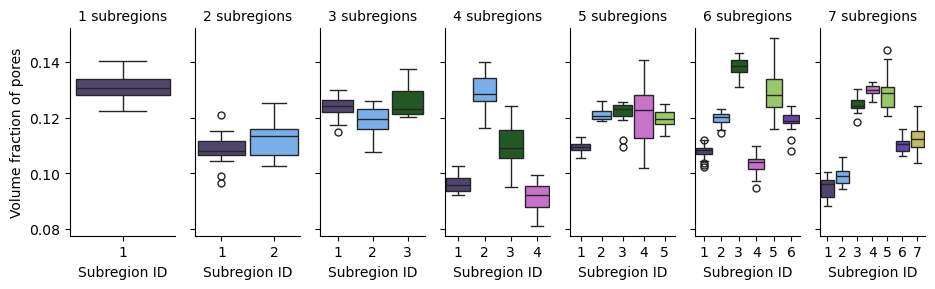

In [7]:
sns.plotting_context('paper')
colors = ["#4c3e76", "#68affc", "#1c5f1e", "#d564d8", "#9ad859", "#5e34bc", "#d6c951"]

go = sns.catplot(data=df_0p2, y="vf pore", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.45, height=3, legend=False)
go.set_axis_labels("Subregion ID", "Volume fraction of pores")
go.set_titles("{col_name} subregions")

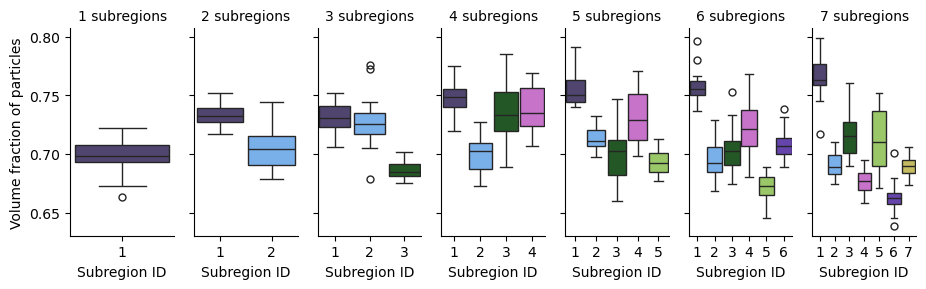

In [8]:
go = sns.catplot(data=df_0p2, y="vf particle", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.45, height=3, legend=False)
go.set_axis_labels("Subregion ID", "Volume fraction of particles")
go.set_titles("{col_name} subregions")

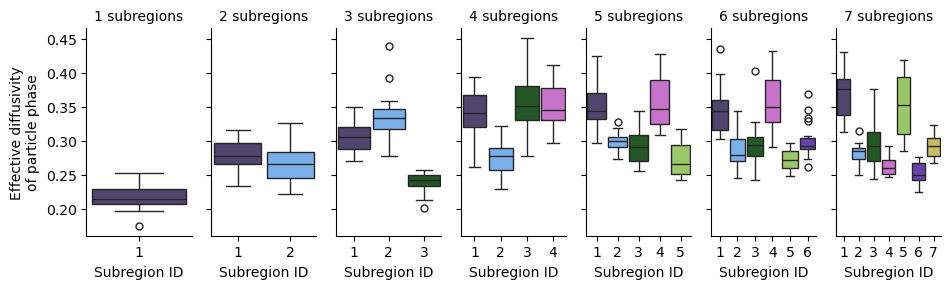

In [9]:
go = sns.catplot(data=df_0p2, y="D eff", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.45, height=3, legend=False)
go.set_axis_labels("Subregion ID", "Effective diffusivity\nof particle phase")
go.set_titles("{col_name} subregions")

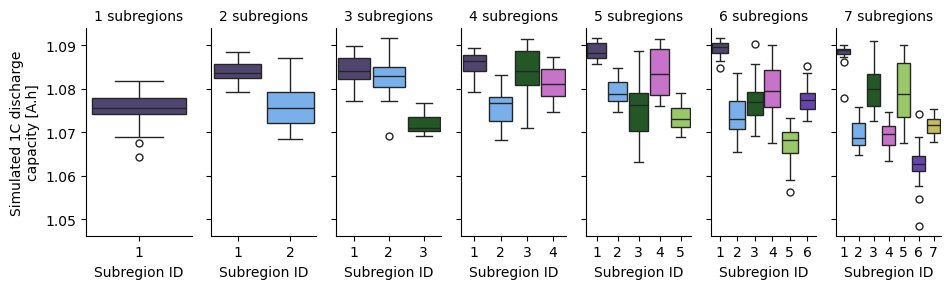

In [18]:
go = sns.catplot(data=df_0p2, y="qdis_1C", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.45, height=3, legend=False)
go.set_axis_labels("Subregion ID", "Simulated 1C discharge\ncapacity [A.h]")
go.set_titles("{col_name} subregions")

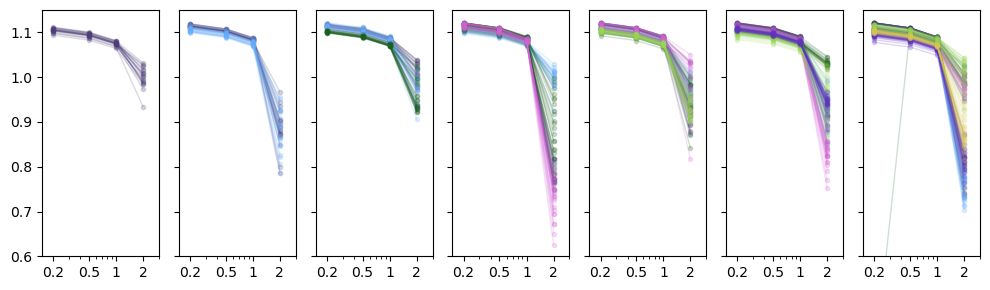

In [48]:
fig, ax = plt.subplots(1, 7, figsize=(10,3), sharey=True)
rates = [0.2, 0.5, 1, 2, 5]
for i in df_0p2.index:
    qdis = np.array([df_0p2.loc[i, 'qdis_Cb5'], df_0p2.loc[i, 'qdis_Cb2'], df_0p2.loc[i, 'qdis_1C'], df_0p2.loc[i, 'qdis_2C'], df_0p2.loc[i, 'qdis_5C']])
    subregions = df_0p2.loc[i, 'subregion']
    subregion_id = df_0p2.loc[i, 'subregion_id']
    ax[subregions-1].semilogx(rates[:-1], qdis[:-1], '-', marker='.', color=colors[subregion_id-1], linewidth=1, alpha=0.2)

for axis in ax:
    axis.set_xticks(rates)
    axis.set_xticklabels(rates)
    axis.set_xlim((0.15, 3))
    axis.set_ylim((0.6, 1.15))

plt.tight_layout()

In [74]:
mask = df_0p2['qdis_Cb5'] > 1
mask_subregions = np.logical_or(df_0p2['subregion'] == 1, df_0p2['subregion'] == 3, df_0p2['subregion'] == 7)
np.logical_and(mask, mask_subregions)

0       True
1       True
2       True
3       True
4       True
       ...  
555    False
556    False
557    False
558    False
559    False
Length: 560, dtype: bool

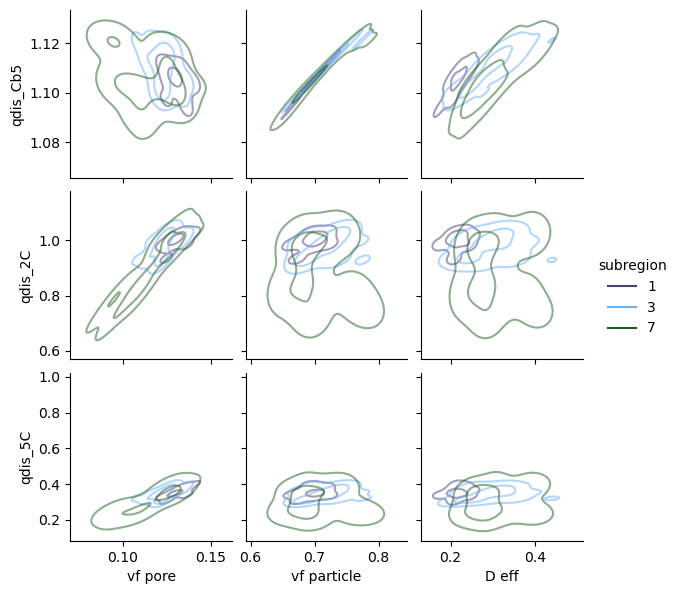

In [76]:

mask = df_0p2['qdis_Cb5'] > 1
mask_subregions = np.logical_or(df_0p2['subregion'] == 1, df_0p2['subregion'] == 3)
mask_subregions = np.logical_or(mask_subregions, df_0p2['subregion'] == 7)
sns.pairplot(df_0p2.loc[np.logical_and(mask, mask_subregions)], hue='subregion', palette=colors[a],
    markers='.', kind='kde',
    y_vars=['qdis_Cb5', 'qdis_2C', 'qdis_5C'],
    x_vars=['vf pore', 'vf particle', 'D eff'],
    height=2, plot_kws={'alpha': 0.5, 'levels': 3})

In [12]:
df_reduction = df[np.logical_and(df['subregion'].values == 1, df['subregion_id'].values == 1)]
df_reduction

,reduction,subregion,subregion_id,vf particle,vf pore,D eff,discharge amphours,voltage,qdis_Cb5,edis_Cb5,qdis_Cb2,edis_Cb2,qdis_1C,edis_1C,qdis_2C,edis_2C,qdis_5C,edis_5C
0,0.2,1,1,0.701879,0.136461,0.227121,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.012889951322405, 3.9560610035299915, 3.923...",1.106378,0.0,1.095393,0.0,1.076857,0.0,1.027128,0.0,0.389183,0.0
1,0.2,1,1,0.698722,0.131375,0.216002,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.012540722032849, 3.9531946593607588, 3.919...",1.105498,0.0,1.094459,0.0,1.075735,0.0,1.008199,0.0,0.356715,0.0
2,0.2,1,1,0.695289,0.128488,0.213814,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.012427876912428, 3.951571514140435, 3.9176...",1.104540,0.0,1.093471,0.0,1.074612,0.0,0.988681,0.0,0.338455,0.0
3,0.2,1,1,0.703854,0.129280,0.208740,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.011768144598291, 3.952611732648217, 3.9193...",1.106883,0.0,1.095830,0.0,1.077064,0.0,1.002901,0.0,0.345371,0.0
4,0.2,1,1,0.715139,0.128921,0.252315,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.010182489136067, 3.9570826810233872, 3.925...",1.109899,0.0,1.098892,0.0,1.080242,0.0,1.016450,0.0,0.365434,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,1,1,0.678169,0.115545,0.319881,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.011315065550214, 3.9505583855862327, 3.915...",1.099523,0.0,1.088455,0.0,1.068785,0.0,0.883721,0.0,0.297783,0.0
636,1.0,1,1,0.671956,0.115589,0.308832,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.011495901906714, 3.949202355216371, 3.9135...",1.097460,0.0,1.086516,0.0,1.066863,0.0,0.876301,0.0,0.293047,0.0
637,1.0,1,1,0.671546,0.114977,0.307165,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.011398235115075, 3.9487894731688593, 3.913...",1.097314,0.0,1.086369,0.0,1.066659,0.0,0.871117,0.0,0.289520,0.0
638,1.0,1,1,0.676477,0.116696,0.315678,"[[0.0, 0.013749818181818184, 0.027499636363636...","[[4.01156672808493, 3.9506406657849364, 3.9155...",1.098983,0.0,1.087962,0.0,1.068389,0.0,0.890140,0.0,0.301976,0.0


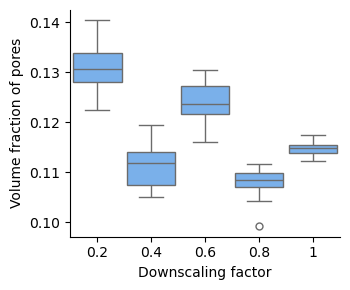

In [13]:
go = sns.catplot(data=df_reduction, y="vf pore", x="reduction", color=colors[1],
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Downscaling factor", "Volume fraction of pores")
go.set_xticklabels((0.2, 0.4, 0.6, 0.8, 1))

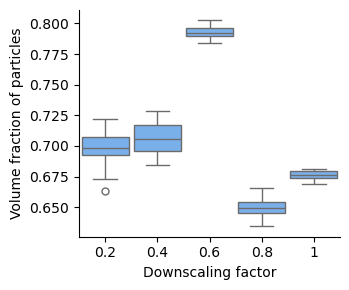

In [14]:
go = sns.catplot(data=df_reduction, y="vf particle", x="reduction", color=colors[1],
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Downscaling factor", "Volume fraction of particles")
go.set_xticklabels((0.2, 0.4, 0.6, 0.8, 1))

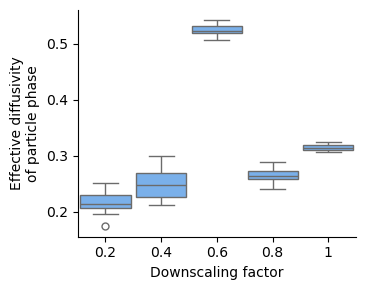

In [15]:
go = sns.catplot(data=df_reduction, y="D eff", x="reduction", color=colors[1],
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Downscaling factor", "Effective diffusivity\nof particle phase")
go.set_xticklabels((0.2, 0.4, 0.6, 0.8, 1))

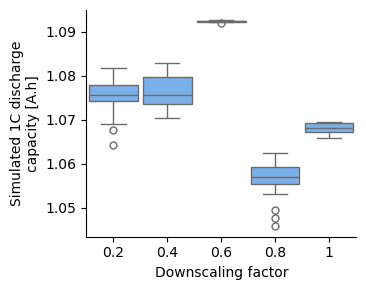

In [17]:
go = sns.catplot(data=df_reduction, y="qdis_1C", x="reduction", color=colors[1],
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=3, legend=False)
go.set_axis_labels("Downscaling factor", "Simulated 1C discharge\ncapacity [A.h]")
go.set_xticklabels((0.2, 0.4, 0.6, 0.8, 1))